## Notebook for apply methodology of evaluate by Otávio

## imports

In [ ]:
import os
import numpy as np
import torch
from functools import partial
from typing import Tuple
from pathlib import Path
import math
import lightning as L
import traceback
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchmetrics import Accuracy, JaccardIndex, F1Score, AUROC, Dice
from minerva.models.loaders import FromPretrained
from minerva.engines.patch_inferencer_engine import PatchInferencer
from minerva.models.nets.image.sam import Sam
from minerva.data.datasets.supervised_dataset import SimpleDataset
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline
from minerva.data.readers.reader import _Reader
from minerva.transforms.transform import _Transform
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.data.data_modules.parihaka import (
    default_train_transforms,
    default_test_transforms,
)
from minerva.utils.typing import PathLike
from minerva.transforms.transform import Indexer, Unsqueeze, Squeeze
from lightning.pytorch.loggers.csv_logs import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from typing import List, Tuple, Optional, Union

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Checking CUDA on node")
print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

Checking CUDA on node
PyTorch Version: 2.6.0+cu124
CUDA Version: 12.4
CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 4090


## Variables

In [ ]:
debug = False

root_data_dir = Path("/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/images")
root_annotation_dir = Path("/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations")
single_channel = True
batch_size = 1

In [4]:
# Partial functions for the TiffReader and PNGReader with numeric sort
# and delimiter "_" for the Parihaka dataset.
TiffReaderWithNumericSort = partial(
    TiffReader, sort_method=["text", "numeric"], delimiter="_", key_index=[0, 1]
)
PNGReaderWithNumericSort = partial(
    PNGReader, sort_method=["text", "numeric"], delimiter="_", key_index=[0, 1]
)

## Datasets for SAM

### Dataset for experiment 3

In [5]:
class DatasetForSAM(SimpleDataset):
    def __init__(
            self, 
            readers: List[_Reader], 
            transforms: Optional[_Transform] = None,
            num_points:int=3
    ):
        super().__init__(readers, transforms)

        assert (
            len(self.readers) == 2
        ), "DatasetForSAM requires exactly 2 readers (image your label)"

        self.num_points = num_points
        self.samples = []
        self._preprocess_data()
    
    def _preprocess_data(self):
        for index in range(len(self.readers[0])):
            data_readers = []
            for reader, transform in zip(self.readers, self.transforms):
                sample = reader[index]
                if transform is not None:
                    sample = transform(sample)
                data_readers.append(sample)
            
            # normalize and add 3 channels (refatored for numpy)
            image = data_readers[0]
            
            if image.shape[0] == 1:
                image = np.repeat(image, 3, axis=0)
            image = np.clip(image * 255, 0, 255).astype(np.uint8)
            
            label = data_readers[1]
            
            num_facies = np.unique(label)
            
            for facie in num_facies:
                region = np.zeros_like(label, dtype=np.uint8) # [H,W]
                region[label == facie] = 1

                point_coords = self.get_points_in_region(region=region, num_points=self.num_points)
                self.samples.append((image, region, point_coords))

    def get_points_in_region(self, region, num_points=3):
        # # Garantir que a região tem apenas valores 0 e 1
        # region = (region > 0).astype(np.uint8)

        # Garantir que a matriz tem apenas duas dimensões removendo a dimensão extra
        if region.ndim == 3 and region.shape[0] == 1:
            region = region.squeeze(0)  # Remove a primeira dimensão (1, H, W) -> (H, W)


        # Verificar se a região contém apenas valores 0 e 1
        unique_values = np.unique(region)
        if not np.array_equal(unique_values, [0, 1]) and not np.array_equal(unique_values, [1]) and not np.array_equal(unique_values, [0]):
            raise ValueError(f"A matriz 'region' contém valores inesperados: {unique_values}. Esperado apenas 0 e 1.")

        # Obter todas as coordenadas (y, x) da região branca
        y_indices, x_indices = np.where(region == 1)

        # Se não houver pontos na região, retornar uma lista vazia
        if len(y_indices) == 0:
            return []

        # Encontrar o centro vertical de cada coluna
        unique_x = np.unique(x_indices)
        central_y_coords = []

        for x in unique_x:
            y_in_column = y_indices[x_indices == x]

            if len(y_in_column) > 0:
                central_y = y_in_column[len(y_in_column) // 2]  # Pega um ponto real, não a média
                central_y_coords.append((x, central_y))

        # Ordenar os pontos pela coordenada x
        central_y_coords = sorted(central_y_coords, key=lambda coord: coord[0])

        # Selecionar pontos equidistantes
        num_points = min(num_points, len(central_y_coords))
        indices = np.linspace(0, len(central_y_coords) - 1, num_points, dtype=int)
        
        selected_points = [central_y_coords[i] for i in indices]

        # Filtrar pontos que realmente pertencem à região branca
        filtered_points = [(int(x), int(round(y)), 1) for x, y in selected_points if region[int(round(y)), int(x)] == 1]

        return filtered_points
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        index: Tuple:
            - (image, label, point_coords)
        """
        image, label, point_coords = self.samples[index]
        
        # preparing points and labels for add with prompt to SAM
        points = [[x, y] for (x, y, value) in point_coords]
        labels = [1] * len(points)

        # image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        original_size = (int(image.shape[1]), int(image.shape[2])) # torch.tensor((int(image.shape[1]), int(image.shape[2])), dtype=torch.long)

        # Verificar se original_size é uma tupla com 2 elementos
        if not isinstance(original_size, tuple) or len(original_size) != 2:
            raise ValueError(f"original_size is not a valid tuple: {original_size}")

        points = torch.tensor(points, dtype=torch.long).unsqueeze(0)  # Adicionando uma dimensão no início
        labels = torch.tensor(labels, dtype=torch.long).unsqueeze(0)  # Adicionando uma dimensão no início
        
        data = {
            'image': image,
            'label': label,
            'original_size': original_size,
            'point_coords': points,
            'point_labels': labels
        }

        return data

## ParihakaDataModule (custom)

In [6]:
class ParihakaDataModule(L.LightningDataModule):
    """Default data module for the Parihaka dataset. This data module creates a
    supervised reconstruction dataset for training, validation, testing, and
    prediction with default transforms to read the images and labels.

    The parihaka dataset is organized as follows:
    root_data_dir
    ├── train
    │   ├── il_1.tif
    |   ├── il_2.tif
    |   ├── ...
    ├── val
    │   ├── il_1.tif
    |   ├── il_2.tif
    |   ├── ...
    ├── test
    │   ├── il_1.tif
    |   ├── il_2.tif
    |   ├── ...
    root_annotation_dir
    ├── train
    │   ├── il_1.png
    |   ├── il_2.png
    |   ├── ...
    ├── val
    │   ├── il_1.png
    |   ├── il_2.png
    |   ├── ...
    ├── test
    │   ├── il_1.png
    |   ├── il_2.png
    |   ├── ...

    The `root_data_dir` contains the seismic images and the
    `root_annotation_dir` contains the corresponding labels. Files with the
    same name in the same directory are assumed to be pairs of seismic images
    and labels. For instance `root_data_dir/train/il_1.tif` and
    `root_annotation_dir/train/il_1.png` are assumed to be a pair of seismic
    image and label.

    Original parihaka dataset contains inlines and crosslines in train and val
    directories. Inlines have dimensions (1006, 590, 3) and crosslines have
    dimensions (1006, 531, 3). By default, crosslines are padded to (1006, 590)
    and all images are transposed to (3, 1006, 590) format. Labels are also
    padded to (1, 1006, 590) and are not transposed. Finally, images are cast to
    float32 and labels are cast to int32.
    """

    def __init__(
        self,
        root_data_dir: PathLike,
        root_annotation_dir: PathLike,
        train_transforms: Optional[Union[_Transform, List[_Transform]]] = None,
        valid_transforms: Optional[Union[_Transform, List[_Transform]]] = None,
        test_transforms: Optional[Union[_Transform, List[_Transform]]] = None,
        num_points:int = 3,
        batch_size: int = 1,
        num_workers: Optional[int] = None,
        drop_last: bool = True,
        data_loader_kwargs: Optional[dict] = None,
    ):
        """Initialize the ParihakaDataModule with the root data and annotation
        directories. The data module is initialized with default training and
        testing transforms.

        Parameters
        ----------
        root_data_dir : str
            Root directory containing the seismic images. Inside this directory
            should be subdirectories `train`, `val`, and `test` containing the
            training, validation, and testing TIFF images.
        root_annotation_dir : str
            Root directory containing the annotations. Inside this directory
            should be subdirectories `train`, `val`, and `test` containing the
            training, validation, and testing PNG annotations. Files with the
            same name in the same directory are assumed to be pairs of seismic
            images and labels.
        train_transforms : Optional[Union[_Transform, List[_Transform]]], optional
            2-element list of transform pipelines for the image and label reader.
            Transforms to apply to the training and validation datasets. If
            None, default training transforms are used, which pads images to
            (1, 1006, 590) and transposes them to (3, 1006, 590) format. Labels
            are also padded to (1006, 590). By default None
        valid_transforms: Optional[Union[_Transform, List[_Transform]]], optional
            2-element list of transform pipelines for the image and label reader.
            Transforms to apply to the validation datasets. If None, default
            training transforms are used, which pads images to (1006, 590) and
            transposes them to (3, 1006, 590) format. Labels are also padded to
            (1, 1006, 590). By default None
        test_transforms : Optional[Union[_Transform, List[_Transform]]], optional
            2-element list of transform pipelines for the image and label reader.
            Transforms to apply to the testing and prediction datasets. If None,
            default testing transforms are used, which transposes images to
            CxHxW format. Labels are untouched. By default None
        num_points : int, optional
            Number of points will be added in sample. Default: 3 points.
        batch_size : int, optional
            Default batch size for the dataloaders, by default 1
        num_workers : Optional[int], optional
            Number of workers for the dataloaders, by default None. If None,
            the number of workers is set to the number of CPUs on the system.
        drop_last : bool, optional
            Whether to drop the last batch if it is smaller than the batch size,
            by default True.
        data_loader_kwargs : Optional[dict], optional
            Aditional keyword arguments to pass to the DataLoader instantiation,
            for training, validation, testing, and prediction dataloaders.
            By default None. Note that, `batch_size`, `num_workers`, and 
            `drop_last` are ignored if passed in this dictionary, as they are
            already presented in the ParihakaDataModule constructor.
        """
        super().__init__()
        self.root_data_dir = Path(root_data_dir)
        self.root_annotation_dir = Path(root_annotation_dir)
        self.train_transforms = train_transforms or default_train_transforms()
        self.valid_transforms = valid_transforms or default_train_transforms()
        self.test_transforms = test_transforms or default_test_transforms()
        self.batch_size = batch_size
        self.num_points = num_points
        self.num_workers = (
            num_workers if num_workers is not None else os.cpu_count()
        )
        self.num_workers = num_workers or 1
        self.drop_last = drop_last
        self.datasets = {}
        
        self.data_loader_kwargs = data_loader_kwargs or {}
        # Update the data loader kwargs with the batch size, num workers, and
        # drop last parameters, passed to the ParihakaDataModule.
        self.data_loader_kwargs.update(
            {
                "batch_size": self.batch_size,
                "num_workers": self.num_workers,
                "drop_last": self.drop_last,
            }
        )
        # Remove the shuffle parameter from the data loader kwargs, as it is
        # handled by the dataloaders.
        self.data_loader_kwargs.pop("shuffle", None)

    def setup(self, stage=None):
        if stage == "fit":
            train_img_reader = TiffReaderWithNumericSort(
                self.root_data_dir / "train"
            )
            train_label_reader = PNGReaderWithNumericSort(
                self.root_annotation_dir / "train",
            )
            train_dataset = DatasetForSAM(
                readers=[train_img_reader, train_label_reader],
                transforms=self.train_transforms,
                num_points=self.num_points
            )

            val_img_reader = TiffReaderWithNumericSort(
                self.root_data_dir / "val",
            )
            val_label_reader = PNGReaderWithNumericSort(
                self.root_annotation_dir / "val",
            )
            val_dataset = DatasetForSAM(
                readers=[val_img_reader, val_label_reader],
                transforms=self.valid_transforms,
                num_points=self.num_points
            )

            self.datasets["train"] = train_dataset
            self.datasets["val"] = val_dataset

        elif stage == "test" or stage == "predict":
            test_img_reader = TiffReaderWithNumericSort(
                self.root_data_dir / "test",
            )
            test_label_reader = PNGReaderWithNumericSort(
                self.root_annotation_dir / "test",
            )
            test_dataset = DatasetForSAM(
                readers=[test_img_reader, test_label_reader],
                transforms=self.test_transforms,
                num_points=self.num_points
            )
            self.datasets["test"] = test_dataset
            self.datasets["predict"] = test_dataset

        else:
            raise ValueError(f"Invalid stage: {stage}")

    def _get_dataloader(self, partition: str, shuffle: bool):
        return DataLoader(
            self.datasets[partition],
            shuffle=shuffle,
            **self.data_loader_kwargs
        )

    def train_dataloader(self):
        return self._get_dataloader("train", shuffle=True)

    def val_dataloader(self):
        return self._get_dataloader("val", shuffle=False)

    def test_dataloader(self):
        return self._get_dataloader("test", shuffle=False)

    def predict_dataloader(self):
        return self._get_dataloader("predict", shuffle=False)

    def __str__(self) -> str:
        return f"""DataModule
    Data: {self.root_data_dir}
    Annotations: {self.root_annotation_dir}
    Batch size: {self.batch_size}"""

    def __repr__(self) -> str:
        return str(self)

## get_data_module (custom)

In [ ]:
def get_data_module(
    root_data_dir: PathLike,
    root_annotation_dir: PathLike,
    img_size: Optional[Tuple[int, int]] = (1006, 590),
    num_points: int = 3,
    batch_size: int = 1,
    num_workers: Optional[int] = None,
    seed: int = 42,
    single_channel: bool = False,
) -> L.LightningDataModule:
    train_transforms = default_train_transforms(img_size=img_size, seed=seed)
    if single_channel:
        train_transforms[0] += Indexer(0)
        train_transforms[0] += Unsqueeze(0)
        train_transforms[1] += Indexer(0)
        train_transforms[1] += Unsqueeze(0)

    test_transforms = default_test_transforms(img_size=img_size, seed=seed)
    if single_channel:
        test_transforms[0] += Indexer(0)
        test_transforms[0] += Unsqueeze(0)
        test_transforms[1] += Indexer(0)
        test_transforms[1] += Unsqueeze(0)

    test_transforms[1] += Squeeze(0)

    return ParihakaDataModule(
        root_data_dir=root_data_dir,
        root_annotation_dir=root_annotation_dir,
        train_transforms=train_transforms,
        valid_transforms=train_transforms,
        test_transforms=test_transforms,
        num_points=num_points,
        batch_size=batch_size,
        num_workers=num_workers,
    )

## Debug: get_data_module

In [8]:
if debug:
    data_module = get_data_module(
        root_data_dir=root_data_dir,
        root_annotation_dir=root_annotation_dir,
        img_size=None,  # Uses original image size (no resize)
        single_channel=single_channel,  # 1 or 3 channels
        batch_size=batch_size,
        seed=42,
        num_workers=os.cpu_count() # originally is 12
    )

    data_module.setup("fit")
    test_train_dataloader = data_module.train_dataloader()
    print("Total batches: ", len(test_train_dataloader))

Total batches:  6549


In [15]:
if debug:
    sample_index = 50  # Escolha o índice desejado
    train_batch = [test_train_dataloader.dataset[sample_index]]

    print(f"Train batch image (X) shape: {train_batch[0]['image'].shape} - type: {type(train_batch[0]['image'])}")
    print(f"Train batch label (Y) shape: {train_batch[0]['label'].shape} - type: {type(train_batch[0]['label'])}")
    print(f"Train batch label (original_size) shape: {train_batch[0]['original_size']} - type: {type(train_batch[0]['original_size'])}")
    print(f"Train batch point_coords shape: {train_batch[0]['point_coords'].shape} - type: {type(train_batch[0]['point_coords'])}")
    print(f"Train batch point_labels shape: {train_batch[0]['point_labels'].shape} - type: {type(train_batch[0]['point_labels'])}")

Train batch image (X) shape: (3, 1006, 531) - type: <class 'numpy.ndarray'>
Train batch label (Y) shape: torch.Size([1, 1006, 531]) - type: <class 'torch.Tensor'>
Train batch label (original_size) shape: (1006, 531) - type: <class 'tuple'>
Train batch point_coords shape: torch.Size([1, 3, 2]) - type: <class 'torch.Tensor'>
Train batch point_labels shape: torch.Size([1, 3]) - type: <class 'torch.Tensor'>


In [16]:
if debug:
    print(f"O Batch (de tamanho {len(train_batch)}) possui: {train_batch[0]['image'].shape[0]} canais, {train_batch[0]['image'].shape[1]} altura e {train_batch[0]['image'].shape[2]} largura.")

O Batch (de tamanho 1) possui: 3 canais, 1006 altura e 531 largura.


shape da image:  torch.Size([3, 1006, 531])
intervalo da image:  tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
shape da label:  torch.Size([1, 1006, 531])
tensor([[[  0, 618],
         [265, 691],
         [530, 735]]])


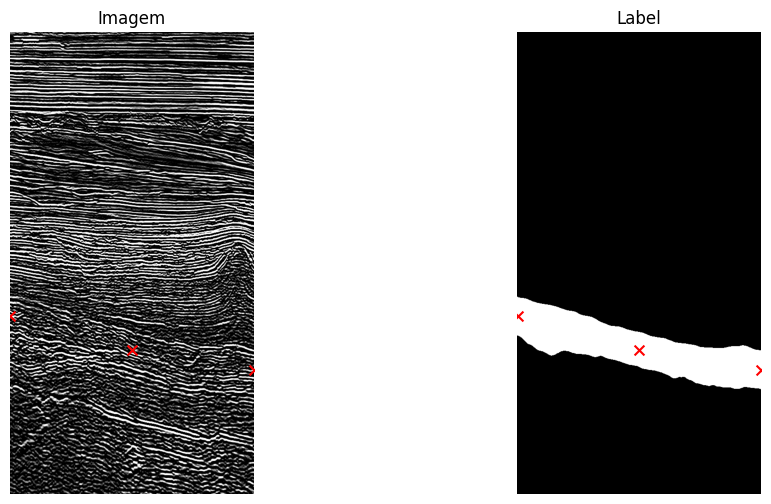

In [17]:
if debug:
    image_tensor = torch.from_numpy(train_batch[0]['image'])

    # Obtendo a imagem e a label do batch
    print("shape da image: ", image_tensor.shape)
    print("intervalo da image: ", torch.min(image_tensor), torch.max(image_tensor))
    print("shape da label: ", train_batch[0]['label'].shape)
    # image = image_tensor.squeeze(0)  # Remover a dimensão do batch (1, 3, 1006, 590) -> (3, 1006, 590)
    # label = train_batch[0]['label'].squeeze(0)  # Remover a dimensão do batch (1, 1, 1006, 590) -> (1, 1006, 590)

    # Transformando para formato adequado para matplotlib
    points = train_batch[0]['point_coords'] # Lista de coordenadas (x, y)
    print(points)
    image = image_tensor.permute(1, 2, 0).cpu().numpy()  # (3, 1006, 590) -> (1006, 590, 3)
    label = train_batch[0]['label'].squeeze(0)  # (1, 1006, 590) -> (1006, 590)

    # Plotando a imagem e a label
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Imagem original
    axes[0].imshow(image)
    axes[0].set_title("Imagem")
    axes[0].axis('off')

    # Plotando os pontos na imagem
    for point in points:
        for y, x in point:
            axes[0].scatter(y, x, color='red', s=50, marker='x', label='Ponto')

    # Label (provavelmente uma máscara ou rótulo binário)
    axes[1].imshow(label, cmap='gray')
    axes[1].set_title("Label")
    axes[1].axis('off')

    # plotando os pontos na label
    for point in points:
        for y, x in point:
            axes[1].scatter(y, x, color='red', s=50, marker='x', label='Ponto')

    plt.show()

## finetuned_models (custom)

In [ ]:
def sam(
        directory:str, 
        single_channel:bool = False,
        num_classes:int = 3,
        multimask_output:bool = True
    ):
    default_ckpt_dir = Path.cwd() / "my_experiments" / "sam_original" / "notebooks" / "checkpoints"
    
    img_size = (1006, 590)
    vit_model = "vit-b"
    ckpt_file = default_ckpt_dir / Path(directory)

    model = Sam(
        vit_type=vit_model,
        return_prediction_only=True,
        num_multimask_outputs=num_classes,
        multimask_output=multimask_output,
        iou_head_depth=num_classes,
        apply_freeze={"image_encoder": False, "prompt_encoder": False, "mask_decoder": False},
        train_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=num_classes)},
        val_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=num_classes)},
        test_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=num_classes)},
        # checkpoint=str(ckpt_file),
    )

    return {
        "name": "sam",
        "model": model,
        "ckpt_file": ckpt_file,
        "img_size": img_size,
        "single_channel": single_channel,
    }

### wrappers

In [ ]:
class PredictorWrapper(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        # Adds a dimension after logits to match PatchInferencer requirements
        # 6x1006x590 -> 6x1x1006x590
        res = self.model(x)
        # For SET-R model, the output is a tuple (y_hat and more 3 aux outputs)
        if isinstance(res, tuple):
            res = res[0]
        res = res.unsqueeze(2)
        return res


class PatchedPredictorWrapper(L.LightningModule):
    def __init__(self, model: PatchInferencer):
        super().__init__()
        self.model = model

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)

    def predict_step(self, batch, batch_idx):
        if not isinstance(batch, torch.Tensor) and len(batch) == 2:
            # print("::Batch is a tuple, unpacking it and passing to patch inferencer")
            batch_x, batch_y = batch
            outputs = self.forward(batch_x)
            # return outputs, batch_y
            return outputs
        else:
            # print("::Batch is not a tuple, passing to patch inferencer normal")
            return self.forward(batch)

### load model

In [ ]:
def load_model(model, ckpt):
    return FromPretrained(model, ckpt, strict=False)

def load_model_from_info(model_info):
    model = model_info["model"]
    ckpt_file = model_info["ckpt_file"]
    return load_model(model, ckpt_file)

In [ ]:
def load_model_and_data_module(
    model_instantiator_func,
    img_shape: Tuple[int, int] = (1006, 590),
    num_points: int = 3,
    n_classes: int = 3,
    batch_size: int = 1,
):
    # Model Info is a dictionary containing information about the model:
    #   name: str
    #   model: L.LightningModule
    #   ckpt_file: Path
    #   img_size: Tuple[int, int]
    #   single_channel: bool
    model_info = model_instantiator_func()

    # ---- 1. Data ----
    data_module = get_data_module(
        root_data_dir=root_data_dir,
        root_annotation_dir=root_annotation_dir,
        img_size=None,  # Uses original image size (no resize)
        single_channel=model_info["single_channel"],  # 1 or 3 channels
        num_points=num_points,
        batch_size=batch_size,
        seed=42,
        num_workers=os.cpu_count()#12
    )

    # ---- 2. Model and wrapper ----

    # Let's check if padding is needed.
    # If shape of model and data is the same, no padding is needed
    if img_shape == model_info["img_size"]:
        pad_dict = None
    else:
        model_h, model_w = model_info["img_size"]
        h_ratio = math.ceil(img_shape[0] / model_h)
        w_ratio = math.ceil(img_shape[1] / model_w)
        pad_dict = {
            "mode": "constant",
            "value": 0,
            "pad": (0, h_ratio * model_h, w_ratio * model_w),
        }

    model_input_shape = (
        1 if model_info["single_channel"] else 3,
        *model_info["img_size"],
    )
    model_output_shape = (n_classes, 1, *model_info["img_size"])

    # Load model
    model = load_model_from_info(model_info)
    model = PredictorWrapper(model)
    model = PatchInferencer(
        model=model,  # type: ignore (as used only for inferencing)
        input_shape=model_input_shape,
        output_shape=model_output_shape,
        padding=pad_dict.copy() if pad_dict else None,
    )
    model = PatchedPredictorWrapper(model)
    model = model.eval()

    # ---- 3. Return ----
    return {
        "model": model,
        "name": model_info["name"],
        "data_module": data_module,
        "ckpt_file": model_info["ckpt_file"],
        "model_input_shape": model_input_shape,
        "model_output_shape": model_output_shape,
        "pad": pad_dict,
        "single_channel": model_info["single_channel"],
        "n_classes": n_classes,
        "batch_size": batch_size,
    }

In [ ]:
def perform_inference(
    model_instantiator_func,
    predictions_path: Path,
    batch_size=1,
    n_classes=3,
    img_shape: Tuple[int, int] = (1006, 590),
    accelerator: str = "gpu",
    devices: int = 1,
):
    model_info = load_model_and_data_module(
        model_instantiator_func=model_instantiator_func,
        img_shape=img_shape,
        n_classes=n_classes,
        batch_size=batch_size,
    )
    print(f"Loading model from ckpt at: {model_info['ckpt_file']}")
    predictions_file = predictions_path / f"{model_info['name']}.npy"
    if predictions_file.exists():
        print(
            f"Predictions already exist at {predictions_file}. Skipping inference."
        )
        return None

    trainer = L.Trainer(
        accelerator=accelerator,
        devices=devices,
        logger=False,
        max_epochs=1,
        enable_checkpointing=False,
    )
    predictions = trainer.predict(
        model_info["model"], model_info["data_module"]
    )
    predictions = torch.stack(predictions, dim=0) # type: ignore
    predictions = predictions.squeeze()
    predictions = predictions.float().cpu().numpy()
    np.save(predictions_file, predictions)
    
    print(f"Predictions saved at {predictions_file}. Shape: {predictions.shape}")
    return predictions_file

In [18]:
def set_default_ckpt_dir(ckpt_dir: Path):
    global default_ckpt_dir
    default_ckpt_dir = ckpt_dir
    print(f"Set default checkpoint directory to {default_ckpt_dir}")

## Execute evaluate

In [ ]:
root_predictions_path = Path.cwd() / "predictions"
finetuned_models_path = [
    Path.cwd() / "checkpoints"
]

for path in finetuned_models_path:
    set_default_ckpt_dir(path)

    predictions_path = root_predictions_path / path.name
    predictions_path.mkdir(parents=True, exist_ok=True)

    for model_instantiator_func in [
        sam
    ]:
        model_name = model_instantiator_func.__name__
        print("-"*80)

        try:
            print("*"*20)
            print(f"Model: {model_name}")
            print("*"*20)
            perform_inference(model_instantiator_func, predictions_path)

Set default checkpoint directory to /workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/checkpoints
--------------------------------------------------------------------------------
